<a href="https://colab.research.google.com/github/AYMAN-CHAREF/computer-vision/blob/main/Probl%C3%A8me_de_classification_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Charger l'ensemble de données

In [1]:
#Charger l'ensemble de données
!pip install mat73
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import mat73
from skimage import data, color
import cv2
from tqdm import tqdm
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:

!wget https://ndownloader.figshare.com/articles/1512427/versions/5
!unzip 5
!unzip brainTumorDataPublic_1-766.zip
!unzip brainTumorDataPublic_1533-2298.zip
!unzip brainTumorDataPublic_767-1532.zip
!unzip brainTumorDataPublic_2299-3064.zip
!rm cvind.mat

--2025-12-29 22:06:15--  https://ndownloader.figshare.com/articles/1512427/versions/5
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 3.255.4.198, 52.208.86.3, 34.248.73.192, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|3.255.4.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  26.0MB/s    in 34s     

2025-12-29 22:06:50 (24.8 MB/s) - ‘5’ saved [879501695/879501695]

Archive:  5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              
Archive:  brainTumorDataPublic_1-766.zip
  inflating: 1.mat                   
  inflating: 10.mat                  
  inflating: 100.mat                 
  inflating: 10

In [5]:
import glob
import numpy as np
from tqdm import tqdm
import mat73
from skimage.transform import rescale

In [6]:
classes = ["meningioma", "glioma", "pituitary"]

def getDataframe(size=128):
    img_list = glob.glob('*.mat')
    print(len(img_list))
    print(img_list[0])

    list_images = []
    list_labels = []

    for img_path in tqdm(img_list):
        dataT = mat73.loadmat(img_path)

        n, m = np.shape(dataT['cjdata']['image'])
        image_rescaled = rescale(
            dataT['cjdata']['image'],
            size / n,
            anti_aliasing=False
        )

        list_images.append(image_rescaled.reshape(size, size))
        list_labels.append(int(dataT['cjdata']['label']) - 1)

    return np.array(list_images), np.array(list_labels)

img_size = 128
images, labels = getDataframe(img_size)


3064
2303.mat


100%|██████████| 3064/3064 [00:41<00:00, 74.46it/s]


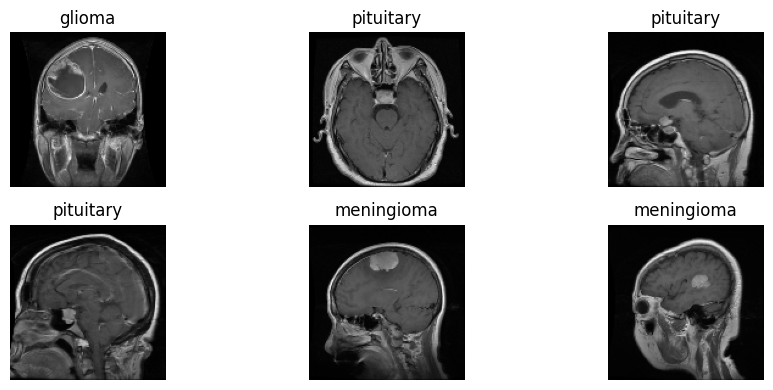

In [7]:

#Visualiser quelques exemples d’apprentissage

plt.figure(figsize=(10, 4))

for i in range(6):
    idx = np.random.randint(0, len(images))
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(classes[labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
#Préparer les données de pixels (normalisation entre 0 et 1)
# Conversion en float32
images = images.astype('float32')

# Normalisation entre 0 et 1
images = images / np.max(images)


In [9]:
print("Valeur min :", images.min())
print("Valeur max :", images.max())


Valeur min : 0.0
Valeur max : 1.0


In [10]:
#4. Partitionner la BD en deux sous-ensembles (80% ensemble d’apprentissage/20% ensemble de test)
from sklearn.model_selection import train_test_split

# Partitionner : 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


print("Taille X_train :", X_train.shape)
print("Taille X_test  :", X_test.shape)
print("Taille y_train :", y_train.shape)
print("Taille y_test  :", y_test.shape)


Taille X_train : (2451, 128, 128)
Taille X_test  : (613, 128, 128)
Taille y_train : (2451,)
Taille y_test  : (613,)


In [11]:
#5. Catégoriser la cible (one hot encoding).
from tensorflow.keras.utils import to_categorical

# Conversion des labels en one-hot
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat  = to_categorical(y_test, num_classes=3)

# Vérification
print("y_train_cat shape :", y_train_cat.shape)
print("Exemple :", y_train_cat[0])


y_train_cat shape : (2451, 3)
Exemple : [1. 0. 0.]


Développer trois modèles de réseau de neurones:

In [12]:
#Modèle 1 : “zéro couche cachée”
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

def perceptron_monocouche_IRM(img_size=128, num_classes=3):
    inp = Input(shape=(img_size, img_size, 1))
    x = Flatten()(inp)
    outp = Dense(num_classes, activation="softmax")(x)
    model = Model(inp, outp)
    model.summary()
    return model


In [13]:
#Modèle 2 : Plusieurs couches cachées (activation sigmoid)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input

def perceptron_multicouche_sig_IRM(img_size=128, num_classes=3):
    model = Sequential()
    model.add(Input(shape=(img_size, img_size, 1)))
    model.add(Flatten())
    model.add(Dense(200, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(30, activation='sigmoid'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model


In [14]:
#Modèle 3 : Plusieurs couches cachées (activation ReLU)
def perceptron_multicouche_relu_IRM(img_size=128, num_classes=3):
    model = Sequential()
    model.add(Input(shape=(img_size, img_size, 1)))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model


In [15]:
import tensorflow as tf

# Paramètres
fc = "categorical_crossentropy"
optim = tf.keras.optimizers.SGD(learning_rate=0.001)
epochs = 100
batch_size = 32

# Créer le modèle
model = perceptron_monocouche_IRM()

# Compiler
model.compile(loss=fc, optimizer=optim, metrics=["accuracy"])

# Entraîner
hist = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        49,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,155 (192.01 KB)

 Trainable params: 49,155 (192.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4022 - loss: 1.0630 - val_accuracy: 0.4649 - val_loss: 0.9695
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4653 - loss: 0.9705 - val_accuracy: 0.4649 - val_loss: 0.9499
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4614 - loss: 0.9548 - val_accuracy: 0.4649 - val_loss: 0.9357
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4719 - loss: 0.9285 - val_accuracy: 0.4649 - val_loss: 0.9227
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4752 - loss: 0.9141 - val_accuracy: 0.4731 - val_loss: 0.9108
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4625 - loss: 0.9238 - val_accuracy: 0.4910 - val_loss: 0.9000
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4871 - loss: 0.9079 - val_accuracy: 0.5188 - val_loss: 0.8901
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5326 - loss: 0.8885 - val_accuracy: 0.5595 - 